# Question 3: CIFAR-10 Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".


PRAKHAR BHARDWAJ

prakharb

Q3

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
import random 
from tqdm import tqdm 
import warnings 

In [2]:
def imshow(img):
  img = img / 2 + 0.5   
  npimg = img.numpy()   
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/train/cifar-10-python.tar.gz to ./CIFAR10/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/test/cifar-10-python.tar.gz to ./CIFAR10/test


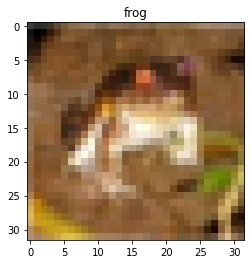

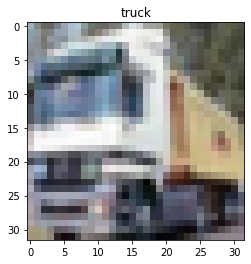

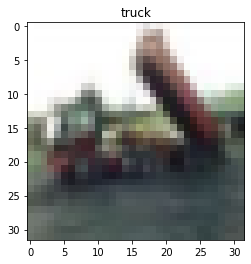

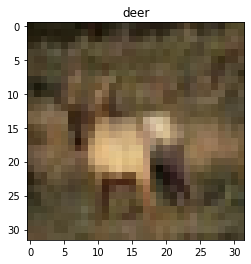

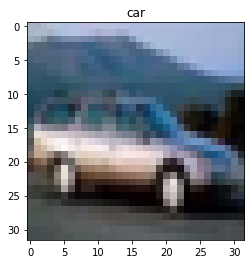

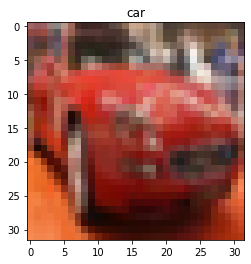

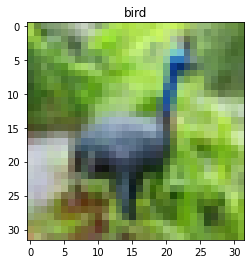

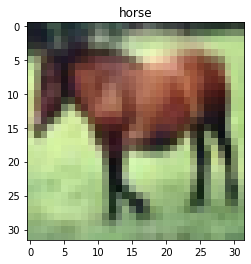

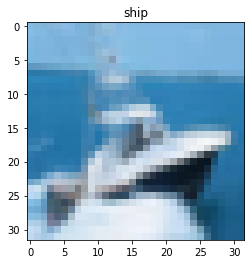

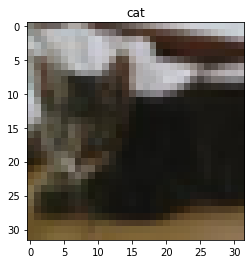

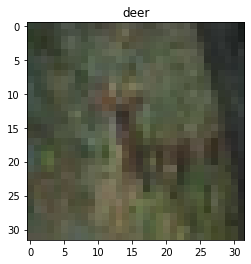

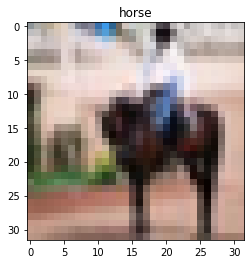

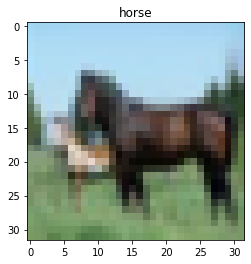

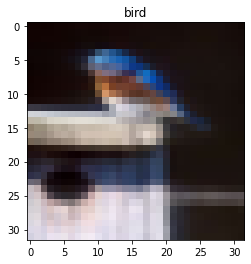

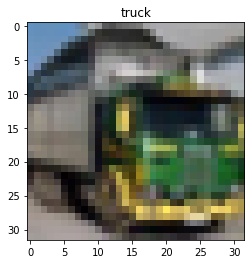

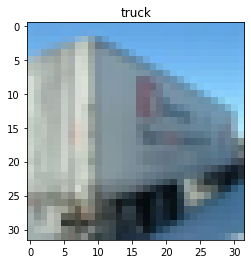

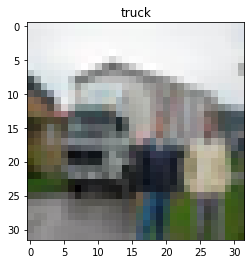

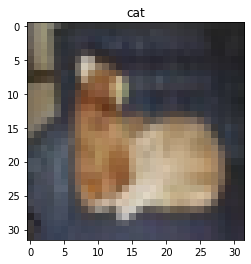

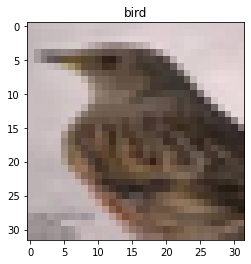

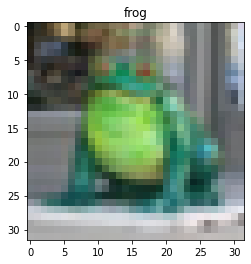

In [3]:
# The below two lines are optional and are just there to avoid any SSL
# related errors while downloading the CIFAR-10 dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5),
                                    std = (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)
    
test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
'frog', 'horse', 'ship', 'truck')

dataiter = iter(train_loader)
imgs, lbls = dataiter.next()

for i in range(20):  
    plt.title(classes[lbls[i]])
    imshow(imgs[i])

In [4]:
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():
    print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
    warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on Tesla T4.......


## P1. Build you own CNN model 
### TODO
- Design your model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **error**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 


###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel

**stride:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll initally use this structure shown below:

*input -> convolution -> fully connected -> output* \\


At the end of the last convolutional layer, we get a tensor of dimension (num_channels, height, width). Since now we are going to feed it to a fully connected layer, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [5]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.relu1 = nn.ReLU()
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.relu2 = nn.ReLU()
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)
    self.relu3 = nn.ReLU()
    self.fc1 = nn.Linear(13824, 120) 
    self.relu4 = nn.ReLU()
    self.fc2=nn.Linear(120,84)
    self.relu5 = nn.ReLU()
    self.fc3=nn.Linear(84,10)
    out=0;
    
  def forward(self,x,fmap=0):

    global out;
    out = self.cnn1(x);
    out = self.relu1(out);
    out = self.cnn2(out);
    out = self.relu2(out);
    
    if fmap==1: 
        plt.imshow(out[0][0].cpu().detach().numpy());
        plt.show();
        plt.close('all');
        q="The feature map is displayed..."
        return q
    
    out = self.cnn3(out);
    out = self.relu3(out);
    out = out = out.view(out.size(0), -1); 
    out = self.fc1(out);
    out = self.relu4(out);
    out = self.fc2(out);
    out = self.relu5(out);
    out = self.fc3(out);
    return out

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [6]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

In [7]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  5%|▌         | 1/20 [00:30<09:42, 30.67s/it]

Iteration: 500  Loss: 1.3864291906356812  Accuracy: 49.52000045776367 %


 10%|█         | 2/20 [00:58<08:37, 28.74s/it]

Iteration: 1000  Loss: 1.2660964727401733  Accuracy: 54.8599967956543 %


 15%|█▌        | 3/20 [01:24<07:52, 27.79s/it]

Iteration: 1500  Loss: 0.9105305075645447  Accuracy: 59.15999984741211 %


 25%|██▌       | 5/20 [02:35<08:11, 32.75s/it]

Iteration: 2000  Loss: 0.9203629493713379  Accuracy: 60.0 %


 30%|███       | 6/20 [03:06<07:30, 32.18s/it]

Iteration: 2500  Loss: 0.8489974737167358  Accuracy: 59.619998931884766 %


 35%|███▌      | 7/20 [03:43<07:18, 33.76s/it]

Iteration: 3000  Loss: 0.9551225304603577  Accuracy: 60.599998474121094 %


 40%|████      | 8/20 [04:17<06:45, 33.80s/it]

Iteration: 3500  Loss: 0.6067119240760803  Accuracy: 59.39999771118164 %


 50%|█████     | 10/20 [05:23<05:35, 33.55s/it]

Iteration: 4000  Loss: 0.6590117812156677  Accuracy: 55.5099983215332 %


 55%|█████▌    | 11/20 [05:58<05:03, 33.71s/it]

Iteration: 4500  Loss: 0.3890983760356903  Accuracy: 58.099998474121094 %


 60%|██████    | 12/20 [06:28<04:21, 32.65s/it]

Iteration: 5000  Loss: 0.4770246744155884  Accuracy: 58.37999725341797 %


 70%|███████   | 14/20 [07:24<03:01, 30.23s/it]

Iteration: 5500  Loss: 0.3367207646369934  Accuracy: 58.31999969482422 %


 75%|███████▌  | 15/20 [07:50<02:25, 29.14s/it]

Iteration: 6000  Loss: 0.22336433827877045  Accuracy: 56.66999816894531 %


 80%|████████  | 16/20 [08:17<01:53, 28.33s/it]

Iteration: 6500  Loss: 0.1199236735701561  Accuracy: 57.769996643066406 %


 85%|████████▌ | 17/20 [08:43<01:22, 27.63s/it]

Iteration: 7000  Loss: 0.1260032057762146  Accuracy: 56.39999771118164 %


 95%|█████████▌| 19/20 [09:36<00:27, 27.22s/it]

Iteration: 7500  Loss: 0.13881933689117432  Accuracy: 55.78999710083008 %


100%|██████████| 20/20 [10:03<00:00, 30.19s/it]


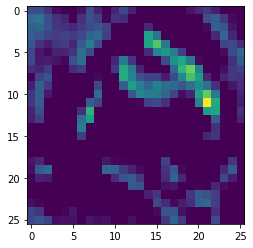

'The feature map is displayed...'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,480
              ReLU-6           [-1, 24, 24, 24]               0
            Linear-7                  [-1, 120]       1,659,000
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 1,674,830
Trainable params: 1,674,830
Non-trainable pa

In [8]:
#Displaying the Feature Map:
images_list=[]
for i,(images,labels) in enumerate(train_loader):
    images, labels= images.to(device) , labels.to(device)
    images_list.append(images)
x_=images_list[0];
y_=model.forward(x_,fmap=1) 
display(y_)
!pip install torchsummary
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))

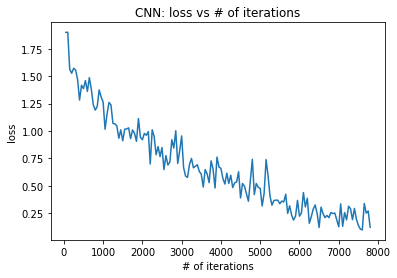

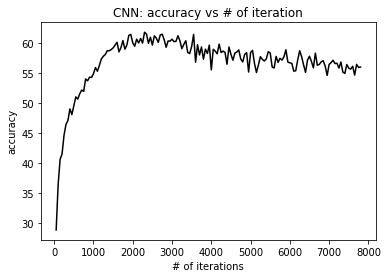

In [9]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("# of iterations")
plt.ylabel("loss")
plt.title("CNN: loss vs # of iterations")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "black")
plt.xlabel("# of iterations")
plt.ylabel("accuracy")
plt.title("CNN: accuracy vs # of iteration")
plt.show()

In [10]:
print("loss is: ", loss_list[-1])
print("accuracy is: ", accuracy_list[-1], "%")

loss is:  0.12205395847558975
accuracy is:  55.96999740600586 %


### Evaluating the Model

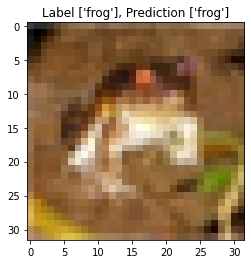

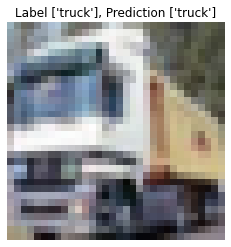

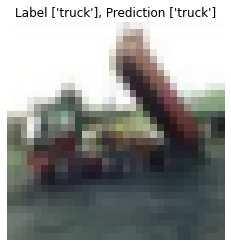

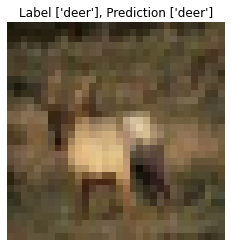

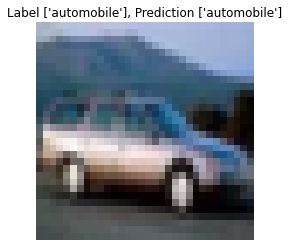

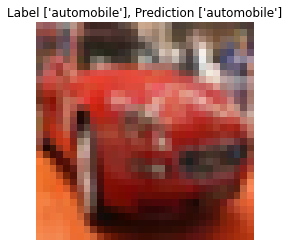

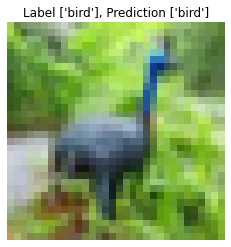

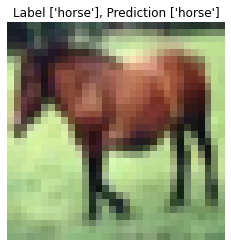

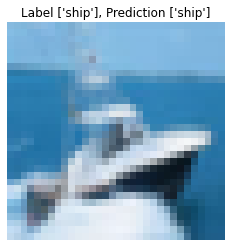

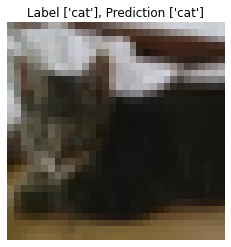

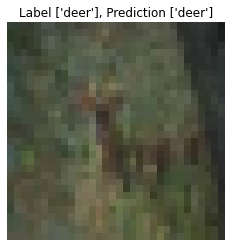

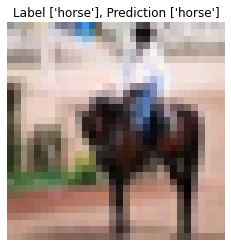

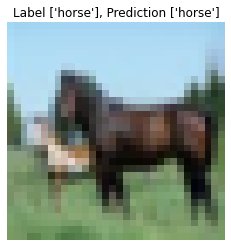

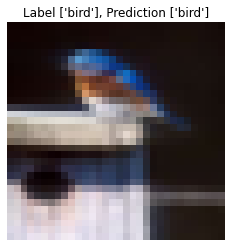

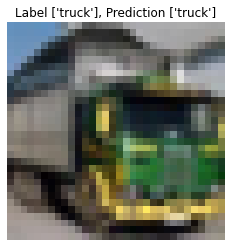

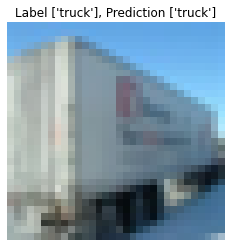

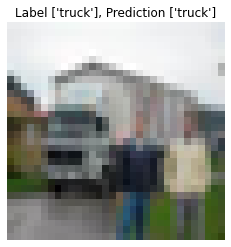

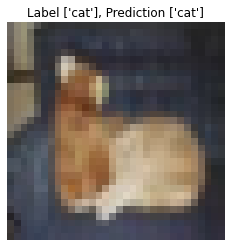

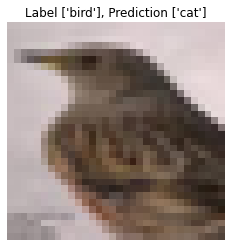

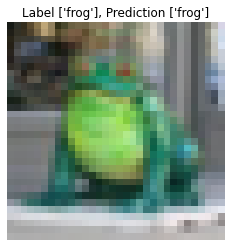

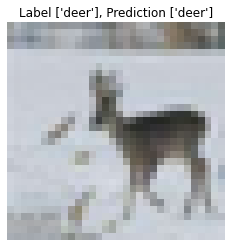

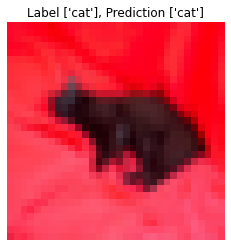

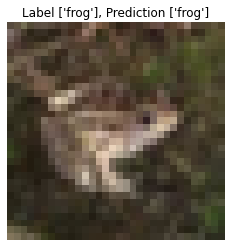

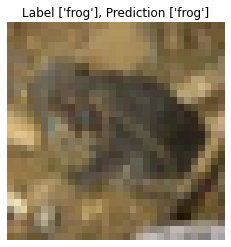

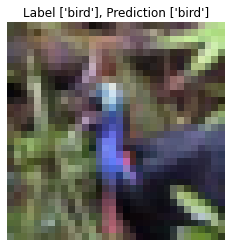

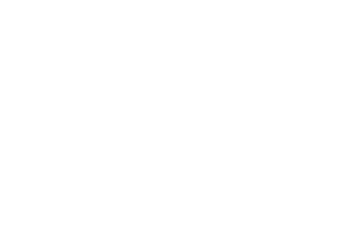

In [11]:
#To-do: evaluate on test set, instead of training set
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = 25# len(labels)
label_map = [['airplane'],['automobile'],['bird'],['cat'], ['deer'], ['dog'], ['frog'], ['horse'], ['ship'], ['truck']]

for idx in range(num_rows):
  img = images.cpu()[idx]
  
  plt.title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")  
  imshow(img)

  plt.axis('off')
plt.show()

### Q3(b) PART - I

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
        # In this function, you should define each of the individual components of the CNN that you will use in your network
        # Example:
        # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        # self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6,
        kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16,
        kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer
        # Example:
        # self.fc1 = nn.Linear(16 *110 * 110, 5)
        # Fully connected 1
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(2904, 120)
        self.relu4 = nn.ReLU()
        self.fc2=nn.Linear(120,84)
        self.relu5 = nn.ReLU()
        self.fc3=nn.Linear(84,10)
        out=0;
    def forward(self,x,fmap="0"): #Giving an argument that decides whether to plot feature map.
        # TODO: Perform forward pass in below section
        # In this function, you will apply the components defined earlier to the input, x.
        # Example:
        # out = self.cnn1(x)
        # out = self.relu1(out)
        # out = self.maxpool1(out)
        global out;
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool1(out)
        if fmap=="1": 
            plt.imshow(out[0][0].cpu().detach().numpy());
            plt.show();
            plt.close('all');
            q="The feature map is displayed..."
            return q
        out = self.cnn3(out)
        out = self.relu3(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.fc2(out)
        out = self.relu5(out)
        out = self.fc3(out)
        return out

In [13]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

The model's estimated total memory is 1.71 MB. It can be seen that the predicted total amount of memory needed in this case has dropped significantly from 6 MBs to 1.71 MBs estimated. The memory size was reduced by using Maxpool and increasing the number of convolutions. This occurred because maxpooling in this case preserves only the crucial characteristics that are required while reducing the resolution of the feature maps and lowering the computational complexity and memory needs.

In [14]:
count = 0
loss_list_b_1 = []
iteration_list_b_1 = []
accuracy_list_b_1 = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = error(outputs,labels)
        
        loss.backward()
        
        optimizer.step()
        count += 1
        
        if count % 50 == 0:
            model.eval()
            
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
               
                predicted = torch.argmax(outputs,1)
                
                total += len(labels)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            loss_list_b_1.append(loss.item())
            iteration_list_b_1.append(count)
            accuracy_list_b_1.append(accuracy.item())
        if count % 500 == 0:
           
            print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))

  5%|▌         | 1/20 [00:25<07:56, 25.09s/it]

Iteration: 500 Loss: 1.368045449256897 Accuracy: 49.14999771118164 %


 10%|█         | 2/20 [00:53<08:02, 26.79s/it]

Iteration: 1000 Loss: 1.4055020809173584 Accuracy: 53.40999984741211 %


 15%|█▌        | 3/20 [01:20<07:37, 26.89s/it]

Iteration: 1500 Loss: 0.977252185344696 Accuracy: 59.15999984741211 %


 25%|██▌       | 5/20 [02:14<06:44, 26.96s/it]

Iteration: 2000 Loss: 1.0432014465332031 Accuracy: 61.03999710083008 %


 30%|███       | 6/20 [02:39<06:06, 26.21s/it]

Iteration: 2500 Loss: 0.8771185278892517 Accuracy: 61.91999816894531 %


 35%|███▌      | 7/20 [03:10<06:01, 27.83s/it]

Iteration: 3000 Loss: 1.2152457237243652 Accuracy: 62.82999801635742 %


 40%|████      | 8/20 [03:37<05:33, 27.75s/it]

Iteration: 3500 Loss: 0.750769853591919 Accuracy: 63.679996490478516 %


 50%|█████     | 10/20 [04:32<04:35, 27.54s/it]

Iteration: 4000 Loss: 0.7613461017608643 Accuracy: 62.14999771118164 %


 55%|█████▌    | 11/20 [04:58<04:04, 27.20s/it]

Iteration: 4500 Loss: 0.6230562925338745 Accuracy: 62.73999786376953 %


 60%|██████    | 12/20 [05:24<03:32, 26.57s/it]

Iteration: 5000 Loss: 0.6249057054519653 Accuracy: 64.25 %


 70%|███████   | 14/20 [06:18<02:40, 26.79s/it]

Iteration: 5500 Loss: 0.7006146907806396 Accuracy: 62.21999740600586 %


 75%|███████▌  | 15/20 [06:45<02:14, 26.97s/it]

Iteration: 6000 Loss: 0.40032389760017395 Accuracy: 62.1099967956543 %


 80%|████████  | 16/20 [07:12<01:48, 27.11s/it]

Iteration: 6500 Loss: 0.4869036078453064 Accuracy: 62.98999786376953 %


 85%|████████▌ | 17/20 [07:38<01:20, 26.75s/it]

Iteration: 7000 Loss: 0.42327460646629333 Accuracy: 61.89999771118164 %


 95%|█████████▌| 19/20 [08:32<00:26, 26.73s/it]

Iteration: 7500 Loss: 0.42832088470458984 Accuracy: 61.459999084472656 %


100%|██████████| 20/20 [08:58<00:00, 26.92s/it]


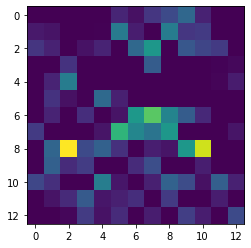

'The feature map is displayed...'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 24, 11, 11]           3,480
              ReLU-7           [-1, 24, 11, 11]               0
            Linear-8                  [-1, 120]         348,600
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 364,430
Trainable params: 364,430
Non-trainable params: 0
-------------------------------

In [15]:
#Displaying the Feature Map:
images_list=[]
for i,(images,labels) in enumerate(train_loader):
    images, labels= images.to(device) , labels.to(device)
    images_list.append(images)
x_=images_list[0];
y_=model.forward(x_,fmap="1") 
display(y_)
#pip install torchsummary
# uncomment above line if you don't have torchsummary installed yet
# Print torchsummary of model
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))

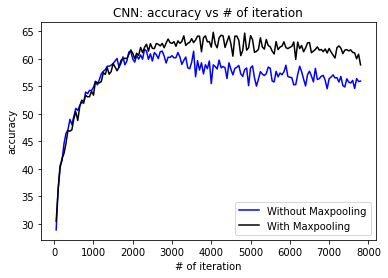

In [16]:
      
# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "blue",label="Without Maxpooling")
plt.plot(iteration_list_b_1,accuracy_list_b_1,color = "black",label="With Maxpooling")
plt.xlabel("# of iteration")
plt.ylabel("accuracy")
plt.title("CNN: accuracy vs # of iteration")
plt.legend()
plt.show()

In [17]:
print("Loss is: ",loss_list_b_1[-1])
print("The Accuracy is: ",accuracy_list_b_1[-1],"%")

Loss is:  0.6212306618690491
The Accuracy is:  58.93000030517578 %


### Q3(b) PART - II

In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
        # In this function, you should define each of the individual components of the CNN that you will use in your network
        # Example:
        # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        # self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.cnn4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.cnn5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=0)
        self.relu5 = nn.ReLU()
        # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer

        self.fc1 = nn.Linear(1176, 120) 
        self.relu4 = nn.ReLU()
        self.fc2=nn.Linear(120,84)
        self.relu5 = nn.ReLU()
        self.fc3=nn.Linear(84,10)
        out=0;
    
    def forward(self,x):
        # TODO: Perform forward pass in below section
        # In this function, you will apply the components defined earlier to the input, x.

        global out;
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool1(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.cnn5(out)
        out = self.relu5(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.fc2(out)
        out = self.relu5(out)
        out = self.fc3(out)
        return out

In [19]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

#!pip install torchsummary
# uncomment above line if you don't have torchsummary installed yet
# Print torchsummary of model

from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 24, 11, 11]           3,480
              ReLU-7           [-1, 24, 11, 11]               0
            Conv2d-8             [-1, 24, 9, 9]           5,208
              ReLU-9             [-1, 24, 9, 9]               0
           Conv2d-10             [-1, 24, 7, 7]           5,208
             ReLU-11             [-1, 24, 7, 7]               0
           Linear-12                  [-1, 120]         141,240
             ReLU-13                  [-1, 120]               0
           Linear-14                   

The model's estimated total memory is 1.00 MB. It can be seen that the predicted total amount of RAM needed in this case has dropped from 1.71 MBs to 1 MB. This occurred because more convolution layers lowered the amount of trainable parameters, resulting in smaller parameters.

In [20]:
count = 0
loss_list_b_2 = []
iteration_list_b_2 = []
accuracy_list_b_2 = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs,labels)
        
        # Backprop agate your Loss
        loss.backward()
        
        # Update CNN model
        optimizer.step()
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list_b_2.append(loss.item())
            iteration_list_b_2.append(count)
            accuracy_list_b_2.append(accuracy.item())
        
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))

  5%|▌         | 1/20 [00:25<08:06, 25.63s/it]

Iteration: 500 Loss: 1.503170371055603 Accuracy: 42.73999786376953 %


 10%|█         | 2/20 [00:52<07:55, 26.42s/it]

Iteration: 1000 Loss: 1.3516991138458252 Accuracy: 46.32999801635742 %


 15%|█▌        | 3/20 [01:19<07:31, 26.56s/it]

Iteration: 1500 Loss: 1.234727144241333 Accuracy: 51.53999710083008 %


 25%|██▌       | 5/20 [02:13<06:46, 27.07s/it]

Iteration: 2000 Loss: 1.195434808731079 Accuracy: 53.73999786376953 %


 30%|███       | 6/20 [02:39<06:09, 26.41s/it]

Iteration: 2500 Loss: 1.175026297569275 Accuracy: 56.88999938964844 %


 35%|███▌      | 7/20 [03:06<05:48, 26.85s/it]

Iteration: 3000 Loss: 1.1799579858779907 Accuracy: 58.709999084472656 %


 40%|████      | 8/20 [03:34<05:24, 27.05s/it]

Iteration: 3500 Loss: 0.9964700937271118 Accuracy: 60.779998779296875 %


 50%|█████     | 10/20 [04:29<04:32, 27.20s/it]

Iteration: 4000 Loss: 0.9923269152641296 Accuracy: 61.619998931884766 %


 55%|█████▌    | 11/20 [04:56<04:03, 27.08s/it]

Iteration: 4500 Loss: 1.0304679870605469 Accuracy: 61.439998626708984 %


 60%|██████    | 12/20 [05:21<03:32, 26.59s/it]

Iteration: 5000 Loss: 1.0006585121154785 Accuracy: 63.04999923706055 %


 70%|███████   | 14/20 [06:16<02:42, 27.11s/it]

Iteration: 5500 Loss: 0.8986901640892029 Accuracy: 63.279998779296875 %


 75%|███████▌  | 15/20 [06:44<02:15, 27.13s/it]

Iteration: 6000 Loss: 0.7552910447120667 Accuracy: 64.04000091552734 %


 80%|████████  | 16/20 [07:11<01:48, 27.19s/it]

Iteration: 6500 Loss: 0.8815488219261169 Accuracy: 65.20999908447266 %


 85%|████████▌ | 17/20 [07:36<01:19, 26.62s/it]

Iteration: 7000 Loss: 0.7173727750778198 Accuracy: 64.12999725341797 %


 95%|█████████▌| 19/20 [08:32<00:27, 27.25s/it]

Iteration: 7500 Loss: 0.8967646956443787 Accuracy: 65.3699951171875 %


100%|██████████| 20/20 [08:59<00:00, 27.00s/it]


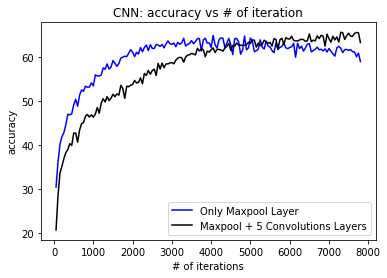

In [21]:
# visualization accuracy
plt.plot(iteration_list_b_1,accuracy_list_b_1,color = "blue",label="Only Maxpool Layer")
plt.plot(iteration_list_b_2,accuracy_list_b_2,color = "black",label="Maxpool + 5 Convolutions Layers")
plt.xlabel("# of iterations")
plt.ylabel("accuracy")
plt.title("CNN: accuracy vs # of iteration")
plt.legend()
plt.show()

In [22]:
print("loss is: ", loss_list_b_2[-1])
print("accuracy is: ", accuracy_list_b_2[-1],"%")

loss is:  0.8047741651535034
accuracy is:  63.25 %


### Q3(b) PART - III

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
        # In this function, you should define each of the individual components of the CNN that you will use in your network
        # Example:
        # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        # self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6*4, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.cnn2 = nn.Conv2d(in_channels=6*4, out_channels=16*4, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(in_channels=16*4, out_channels=24*4, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.cnn4 = nn.Conv2d(in_channels=24*4, out_channels=24*4, kernel_size=3, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.cnn5 = nn.Conv2d(in_channels=24*4, out_channels=24*4, kernel_size=3, stride=1, padding=0)
        self.relu5 = nn.ReLU()
        # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer
        # Example:
        # self.fc1 = nn.Linear(16 *110 * 110, 5)
        # Fully connected 1
        self.fc1 = nn.Linear(4704, 120)
        self.relu4 = nn.ReLU()
        self.fc2=nn.Linear(120,84)
        self.relu5 = nn.ReLU()
        self.fc3=nn.Linear(84,10)
        out=0;

    def forward(self,x):
        # TODO: Perform forward pass in below section
        # In this function, you will apply the components defined earlier to the input, x.
 
        global out;
        # to visualize feature map in part a, part b.i), use the following three lines:

        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool1(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.cnn5(out)
        out = self.relu5(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.fc2(out)
        out = self.relu5(out)
        out = self.fc3(out)
        return out

In [24]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)
# TODO: define Cross Entropy Loss
error = nn.CrossEntropyLoss()
# TODO: create Adam Optimizer and define your hyperparameters
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20
#!pip install torchsummary
# uncomment above line if you don't have torchsummary installed yet
# Print torchsummary of model
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]           1,824
              ReLU-2           [-1, 24, 28, 28]               0
            Conv2d-3           [-1, 64, 26, 26]          13,888
              ReLU-4           [-1, 64, 26, 26]               0
         MaxPool2d-5           [-1, 64, 13, 13]               0
            Conv2d-6           [-1, 96, 11, 11]          55,392
              ReLU-7           [-1, 96, 11, 11]               0
            Conv2d-8             [-1, 96, 9, 9]          83,040
              ReLU-9             [-1, 96, 9, 9]               0
           Conv2d-10             [-1, 96, 7, 7]          83,040
             ReLU-11             [-1, 96, 7, 7]               0
           Linear-12                  [-1, 120]         564,600
             ReLU-13                  [-1, 120]               0
           Linear-14                   

It can be seen that the total amount of RAM needed in this case has increased from 1 MB to 4.51 MBs. This occurred because there were more processing demands for the forward and backward pass computation as there were more channels.

In [25]:
count = 0
loss_list_b_3 = []
iteration_list_b_3 = []
accuracy_list_b_3 = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)        
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs,labels)
        
        # Backprop agate your Loss
        loss.backward()
        
        # Update CNN model
        optimizer.step()
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)

                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)

                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)
            # store loss and iteration
            loss_list_b_3.append(loss.item())
            iteration_list_b_3.append(count)
            accuracy_list_b_3.append(accuracy.item())
        
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))

  5%|▌         | 1/20 [00:25<08:09, 25.77s/it]

Iteration: 500 Loss: 1.367837905883789 Accuracy: 49.209999084472656 %


 10%|█         | 2/20 [00:53<08:06, 27.00s/it]

Iteration: 1000 Loss: 1.1216003894805908 Accuracy: 57.68000030517578 %


 15%|█▌        | 3/20 [01:21<07:47, 27.49s/it]

Iteration: 1500 Loss: 0.9826357364654541 Accuracy: 63.65999984741211 %


 25%|██▌       | 5/20 [02:18<06:59, 27.98s/it]

Iteration: 2000 Loss: 0.9021921753883362 Accuracy: 67.0999984741211 %


 30%|███       | 6/20 [02:44<06:22, 27.30s/it]

Iteration: 2500 Loss: 0.7987403273582458 Accuracy: 68.25999450683594 %


 35%|███▌      | 7/20 [03:12<05:56, 27.45s/it]

Iteration: 3000 Loss: 0.8687425255775452 Accuracy: 71.16999816894531 %


 40%|████      | 8/20 [03:39<05:30, 27.50s/it]

Iteration: 3500 Loss: 0.5592045187950134 Accuracy: 69.83000183105469 %


 50%|█████     | 10/20 [04:35<04:37, 27.74s/it]

Iteration: 4000 Loss: 0.5500035285949707 Accuracy: 68.97999572753906 %


 55%|█████▌    | 11/20 [05:03<04:09, 27.72s/it]

Iteration: 4500 Loss: 0.5464893579483032 Accuracy: 65.33999633789062 %


 60%|██████    | 12/20 [05:28<03:35, 27.00s/it]

Iteration: 5000 Loss: 0.5220396518707275 Accuracy: 70.1199951171875 %


 70%|███████   | 14/20 [06:24<02:44, 27.50s/it]

Iteration: 5500 Loss: 0.5305044651031494 Accuracy: 70.6500015258789 %


 75%|███████▌  | 15/20 [06:52<02:17, 27.56s/it]

Iteration: 6000 Loss: 0.2897247076034546 Accuracy: 69.94999694824219 %


 80%|████████  | 16/20 [07:20<01:50, 27.53s/it]

Iteration: 6500 Loss: 0.37162014842033386 Accuracy: 70.36000061035156 %


 85%|████████▌ | 17/20 [07:46<01:21, 27.16s/it]

Iteration: 7000 Loss: 0.3003513216972351 Accuracy: 68.6500015258789 %


 95%|█████████▌| 19/20 [08:40<00:27, 27.14s/it]

Iteration: 7500 Loss: 0.37007105350494385 Accuracy: 70.23999786376953 %


100%|██████████| 20/20 [09:08<00:00, 27.41s/it]


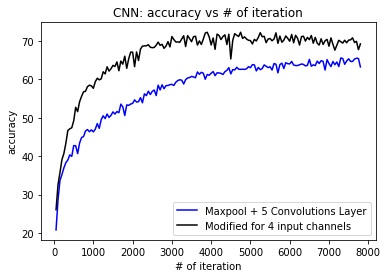

In [26]:
# visualization accuracy
plt.plot(iteration_list_b_2,accuracy_list_b_2,color = "blue",label="Maxpool + 5 Convolutions Layer")
plt.plot(iteration_list_b_3,accuracy_list_b_3,color = "black",label="Modified for 4 input channels")
plt.xlabel("# of iteration")
plt.ylabel("accuracy")
plt.title("CNN: accuracy vs # of iteration")
plt.legend()
plt.show()

In [27]:
print("loss is: ",loss_list_b_3[-1])
print("accuracy is: ",accuracy_list_b_3[-1],"%")

loss is:  0.23445750772953033
accuracy is:  69.25 %
